# Learning the basics

In [8]:
import matplotlib.pyplot as plt

In [9]:
import os
os.chdir("../")

## Simulation 

In [10]:
plt.rcParams['figure.figsize'] = (4,3)

In [11]:
from results.simulation import simulation

In [12]:
simulator = simulation(hetero_value=1e-1, coef=2)

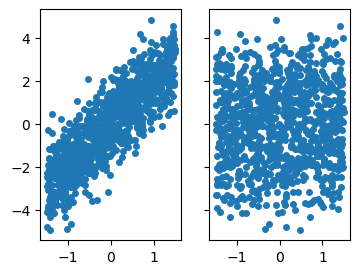

In [13]:
simulator.homoscedastic(10**3)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.plot(simulator.X[:, 0], simulator.y, 'o', ms=4)
ax2.plot(simulator.X[:, 1], simulator.y, 'o', ms=4)
plt.show()

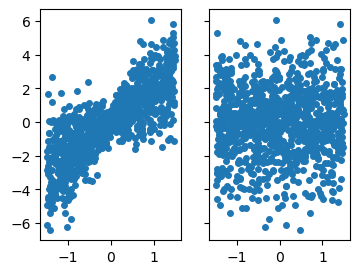

In [14]:
simulator.heteroscedastic(10**3)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.plot(simulator.X[:, 0], simulator.y, 'o', ms=4)
ax2.plot(simulator.X[:, 1], simulator.y, 'o', ms=4)
plt.show()

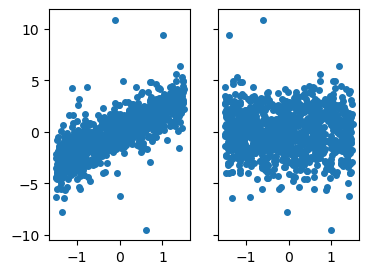

In [15]:
simulator.t_residuals(10**3)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.plot(simulator.X[:, 0], simulator.y, 'o', ms=4)
ax2.plot(simulator.X[:, 1], simulator.y, 'o', ms=4)
plt.show()

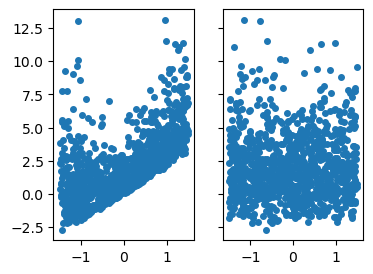

In [16]:
simulator.asymmetric(10**3)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.plot(simulator.X[:, 0], simulator.y, 'o', ms=4)
ax2.plot(simulator.X[:, 1], simulator.y, 'o', ms=4)
plt.show()

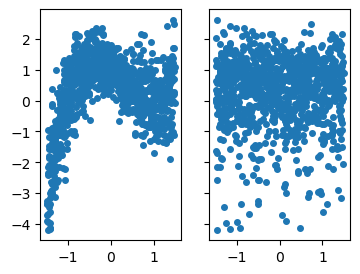

In [17]:
simulator.bimodal(10**3)
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True)
ax1.plot(simulator.X[:, 0], simulator.y, 'o', ms=4)
ax2.plot(simulator.X[:, 1], simulator.y, 'o', ms=4)
plt.show()

# Marginal coverage

## Conformalized quantile regression

Here, we are seeking to guarantee only marginal coverage.

In [43]:
import numpy as np
from sklearn.model_selection import train_test_split

from lcv.models import QuantileGradientBoosting

In [44]:
def coverage_fraction(y, y_low, y_high):
    return np.mean(np.logical_and(y >= y_low, y <= y_high))

In [45]:
rng = np.random.RandomState(10)

In [62]:
sim = simulation()
sim.homoscedastic(10**3)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(sim.X, sim.y, test_size=0.2, random_state=rng)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.3)

In [64]:
alpha = 0.05
qgb = QuantileGradientBoosting(alpha=alpha, random_state=rng)

In [65]:
qgb.fit(X_train, y_train)

QuantileGradientBoosting(random_state=RandomState(MT19937) at 0x7FB08A82F640)

In [81]:
train_pred = qgb.predict(X_train)
calib_pred = qgb.predict(X_calib)
test_pred = qgb.predict(X_test)

In [82]:
coverage_fraction(y_train, train_pred[:, 0], train_pred[:, 1])

0.9428571428571428

In [83]:
coverage_fraction(y_test, test_pred[:, 0], test_pred[:, 1])

0.935

### Calibrating

In [84]:
from lcv.scores import QuantileScore

In [85]:
s = np.max(np.c_[calib_pred[:,0] - y_calib, y_calib - calib_pred[:,1]], axis=1)

In [86]:
n = X_calib.shape[0]

In [87]:
qhat = np.quantile(s, np.ceil((n+1)*(1-alpha))/n)

In [88]:
lower_valid  = test_pred[:,0] - qhat
upper_valid = test_pred[:,1] + qhat

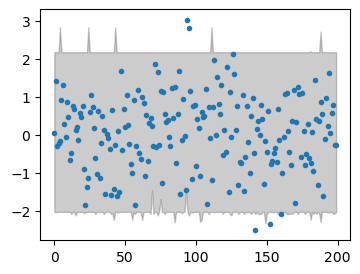

In [90]:
plt.plot(y_test, 'o', ms=3)
plt.fill_between(np.arange(y_test.size), lower_valid, upper_valid, color='k', alpha=0.2)
plt.show()

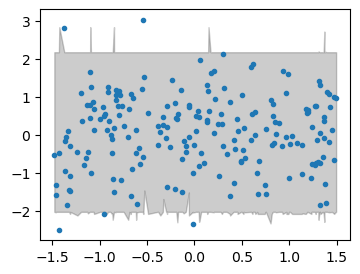

In [91]:
ordered_X  = np.argsort(X_test[:, 0])
plt.plot(X_test[:, 0][ordered_X], y_test[ordered_X], 'o', ms=3)
plt.fill_between(X_test[:, 0][ordered_X], lower_valid, upper_valid, color='k', alpha=0.2)
plt.show()

In [92]:
coverage_fraction(y_test, lower_valid, upper_valid)

0.98

# Local conditional coverage

In [106]:
from lcv.utils import real_coverage, compute_interval_length

## Generate data

In [107]:
rng = np.random.RandomState(0)

In [108]:
X_test = rng.uniform(low=-1.5, high=1.5, size=(5*10**3, 20))

In [109]:
y_mat = simulator.homoscedastic_r(X_test[:, 0], B=10**3)

In [110]:
simulator.heteroscedastic(500, random_seed=0)

In [111]:
X_train, X_calib, y_train, y_calib = train_test_split(sim.X, sim.y, test_size=0.5, random_state=rng)

## Locluster

In [112]:
from lcv.scores import QuantileScore, RegressionScore
from lcv.locluster import KmeansSplit, GradientBoostingQuantileEnsemble

In [113]:
from sklearn.ensemble import RandomForestRegressor

In [114]:
locluster = KmeansSplit(QuantileScore, QuantileGradientBoosting, alpha=0.05)

In [115]:
locluster

KmeansSplit(alpha=0.05, base_model=QuantileGradientBoosting(),
            nc_score=<lcv.scores.QuantileScore object at 0x7fb08a520250>)

In [116]:
locluster.fit(X_train, y_train)

KmeansSplit(alpha=0.05, base_model=QuantileGradientBoosting(),
            nc_score=<lcv.scores.QuantileScore object at 0x7fb08a520250>)

In [117]:
locluster.calib(X_calib, y_calib, tune_k=True)

array([0.08682709, 0.17790308])

In [118]:
y_pred = np.array(locluster.predict(X_test, length=1000))

In [119]:
y_pred

array([[-1.9641281 ,  1.97357894],
       [-1.86719993,  1.87665077],
       [-1.9641281 ,  1.97357894],
       ...,
       [-1.86719993,  1.87665077],
       [-1.9641281 ,  1.97357894],
       [-1.86719993,  2.009927  ]])

In [120]:
np.mean(real_coverage(y_pred, y_mat))

0.6172468000000001

In [121]:
np.mean(compute_interval_length(y_pred))

3.8483974203434372

## Locart

In [122]:
from lcv.locart import LocartSplit

In [123]:
locart = LocartSplit(QuantileScore, QuantileGradientBoosting, alpha=0.05)

In [124]:
locart

LocartSplit(alpha=0.05, base_model=QuantileGradientBoosting(),
            nc_score=<lcv.scores.QuantileScore object at 0x7fb0841d8c40>)

In [125]:
locart.fit(X_train, y_train)

LocartSplit(alpha=0.05, base_model=QuantileGradientBoosting(),
            nc_score=<lcv.scores.QuantileScore object at 0x7fb0841d8c40>)

In [126]:
locart.calib(X_calib, y_calib)

array([0.15671115])

In [127]:
y_pred = np.array(locart.predict(X_test, length=2000))

In [128]:
np.mean(real_coverage(y_pred, y_mat))

0.6222878

In [129]:
np.mean(compute_interval_length(y_pred))

3.882379503280212